# Решение задачи классификации с помощью градиентного бустинга деревьев решений

## Импорт библиотек

In [1]:
import sklearn
import numpy as np
import pandas as pd
from sklearn import datasets

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate


## Загрузка датасета

Для построения моделей я использую датасет с типами покрытий лесных массивов в квадратах 30х30 метров. Датасет содержит 580к строк и 7 классов

In [4]:
ctypes = sklearn.datasets.fetch_covtype(as_frame = True)

In [5]:
ctypes.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [6]:
print(ctypes.get('DESCR'))

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

In [7]:
data = ctypes.get('data')
target = ctypes.get('target')

In [ ]:
#data = data.drop(columns=["target"], axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

In [ ]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 581012 entries, 0 to 581011
Series name: Cover_Type
Non-Null Count   Dtype
--------------   -----
581012 non-null  int32
dtypes: int32(1)
memory usage: 2.2 MB


In [ ]:
target.head()

0    5
1    5
2    2
3    2
4    5
Name: Cover_Type, dtype: int32

In [ ]:
print(target.unique())
print(target.value_counts().sort_index())

[5 2 1 7 3 6 4]
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: Cover_Type, dtype: int64


Датасет не сбалансирован, так как колличество элементов классов различно, различие между самым многочисленным и самым малочисленным классом почти в 78 раз.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=True)

Разделим сырые данные на обучающую и тестовую выборки, чтобы посмотреть эффективность моделей обучения на них

## Создание моделей обучения на сырых данных

### Логистическая регрессия

Для няглядного выявления разницы между методом градиентного бустинга и других моделей обучения, создадим модель логистической регрессии, так как она не требует обязательной настройки и подбора параметров

In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = lr.predict(x_test)

In [ ]:
np.unique(y_pred, return_counts=True) #предсказанные значения

(array([1, 2, 3, 6, 7], dtype=int32),
 array([43170, 69903,  2843,   200,    87]))

In [ ]:
np.unique(y_test, return_counts=True) #действительные значения

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([42275, 56602,  7269,   546,  1929,  3496,  4086]))

Как видно по колличеству значений каждого класса, модель не научилась определять классы 4 и 5, классы 6 и 7 она определяет крайне плохо

Text(0.5, 177.0, 'Предсказанные значения')

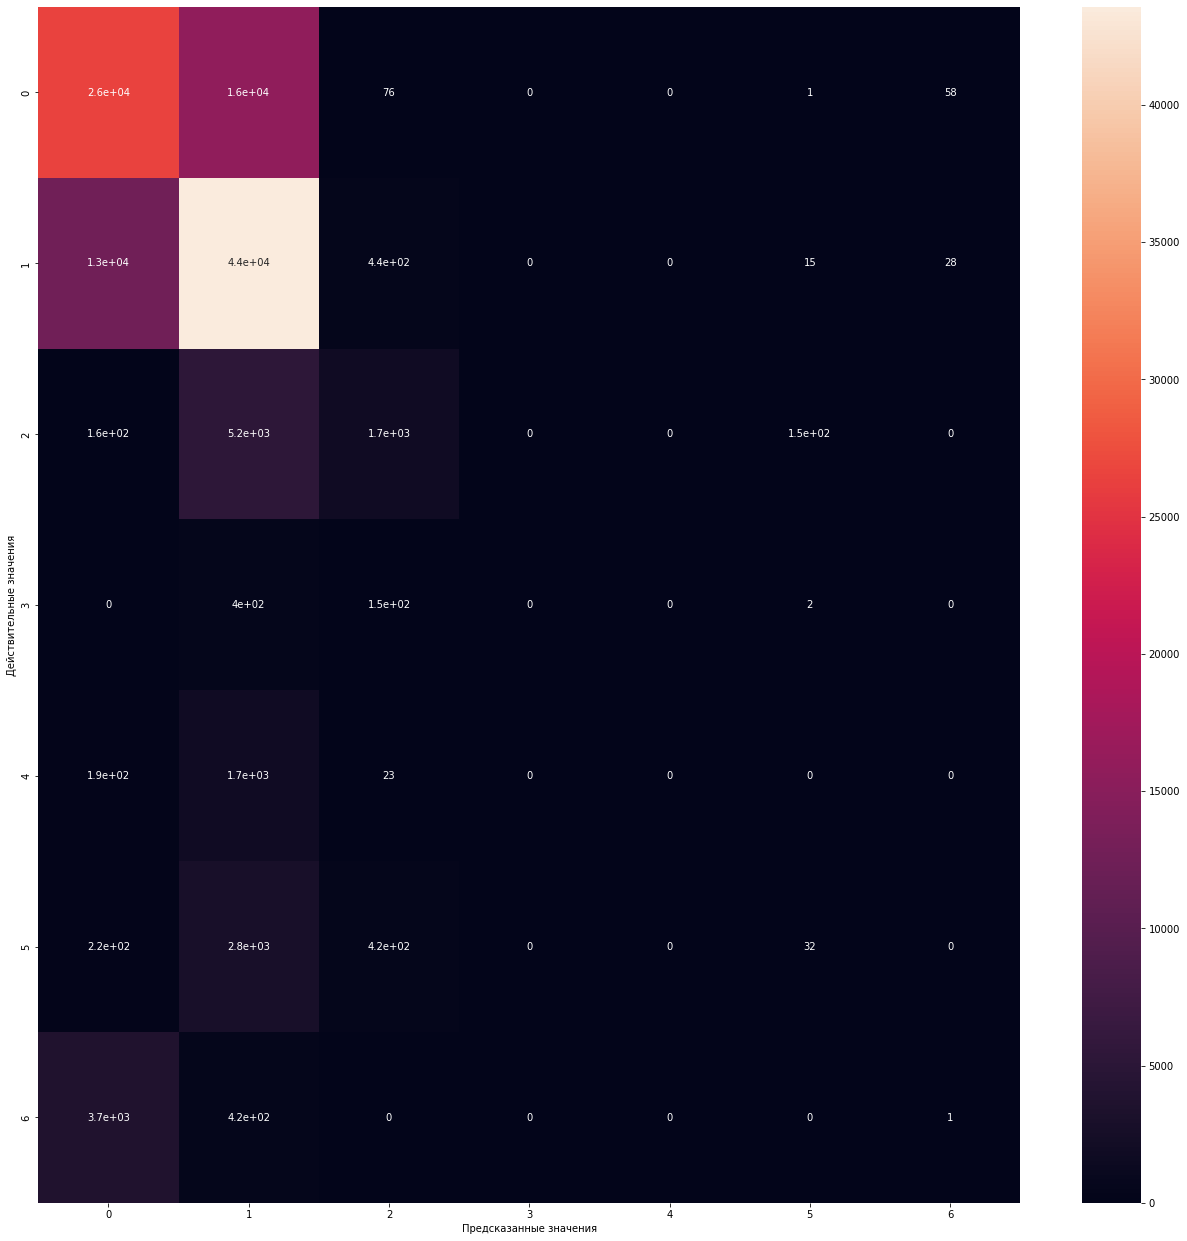

In [ ]:
%matplotlib inline

class_names = [1, 2, 3, 4, 5, 6, 7]
fig, ax = plt.subplots(figsize=(22, 22))

ticks = np.arange(len(class_names))

#Добавлем ось x
plt.xticks(ticks, class_names)
#Добавляем ось y
plt.yticks(ticks, class_names)

#Строим матрицу при помощи sns
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)), annot=True)
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения')

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.6173764876982522

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.61      0.62      0.62     42275
           2       0.62      0.77      0.69     56602
           3       0.61      0.24      0.34      7269
           4       0.00      0.00      0.00       546
           5       0.00      0.00      0.00      1929
           6       0.16      0.01      0.02      3496
           7       0.01      0.00      0.00      4086

    accuracy                           0.62    116203
   macro avg       0.29      0.23      0.24    116203
weighted avg       0.57      0.62      0.58    116203



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Соответственно метрика точности у неё крайне малая

### Метод градиентного бустинга на сырых данных

Путём последовательного бодбора параметров я установил у метода:
- Колличество стадий бустинга: 30 оптимально выдает 74% точности, можно повысить до 50 для получения точности 75,5%;
- Скорость обучения: 0.1, скорость обучения выше снижает точность, снижение скорости не целесообразно;
- Максимальная глубина отдельной стадии: 3, при глубине шага больше снижается точность, при глубине шага меньше соразмерно повышается время выполнения без видимого улучшения точности;
Дополнительно зерно случайных величин пока установил 0

In [ ]:
gbc_raw = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, max_depth=3, random_state=0)

In [ ]:
gbc_raw.fit(x_train, y_train)

GradientBoostingClassifier(n_estimators=30, random_state=0)

In [ ]:
y_pred2 = gbc_raw.predict(x_test)

In [ ]:
y_pred2

array([2, 1, 3, ..., 1, 2, 1], dtype=int32)

In [ ]:
np.unique(y_pred2, return_counts=True) #предсказанные значения

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([41885, 60481,  8655,   459,   525,  1263,  2935]))

In [ ]:
np.unique(y_test, return_counts=True) #действительные значения

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([42275, 56602,  7269,   546,  1929,  3496,  4086]))

In [ ]:
metrics.accuracy_score(y_test, y_pred2)

0.7428895983752571

Как видно, даже на сырых данных модель на основе градиентного бустинга показывает лучший результат, по крайней мере потому что она может определять классы 4 и 5. Однако точность в 74-75% по моему мнению всё ещё не является достаточной

Text(0.5, 177.0, 'Предсказанные значения')

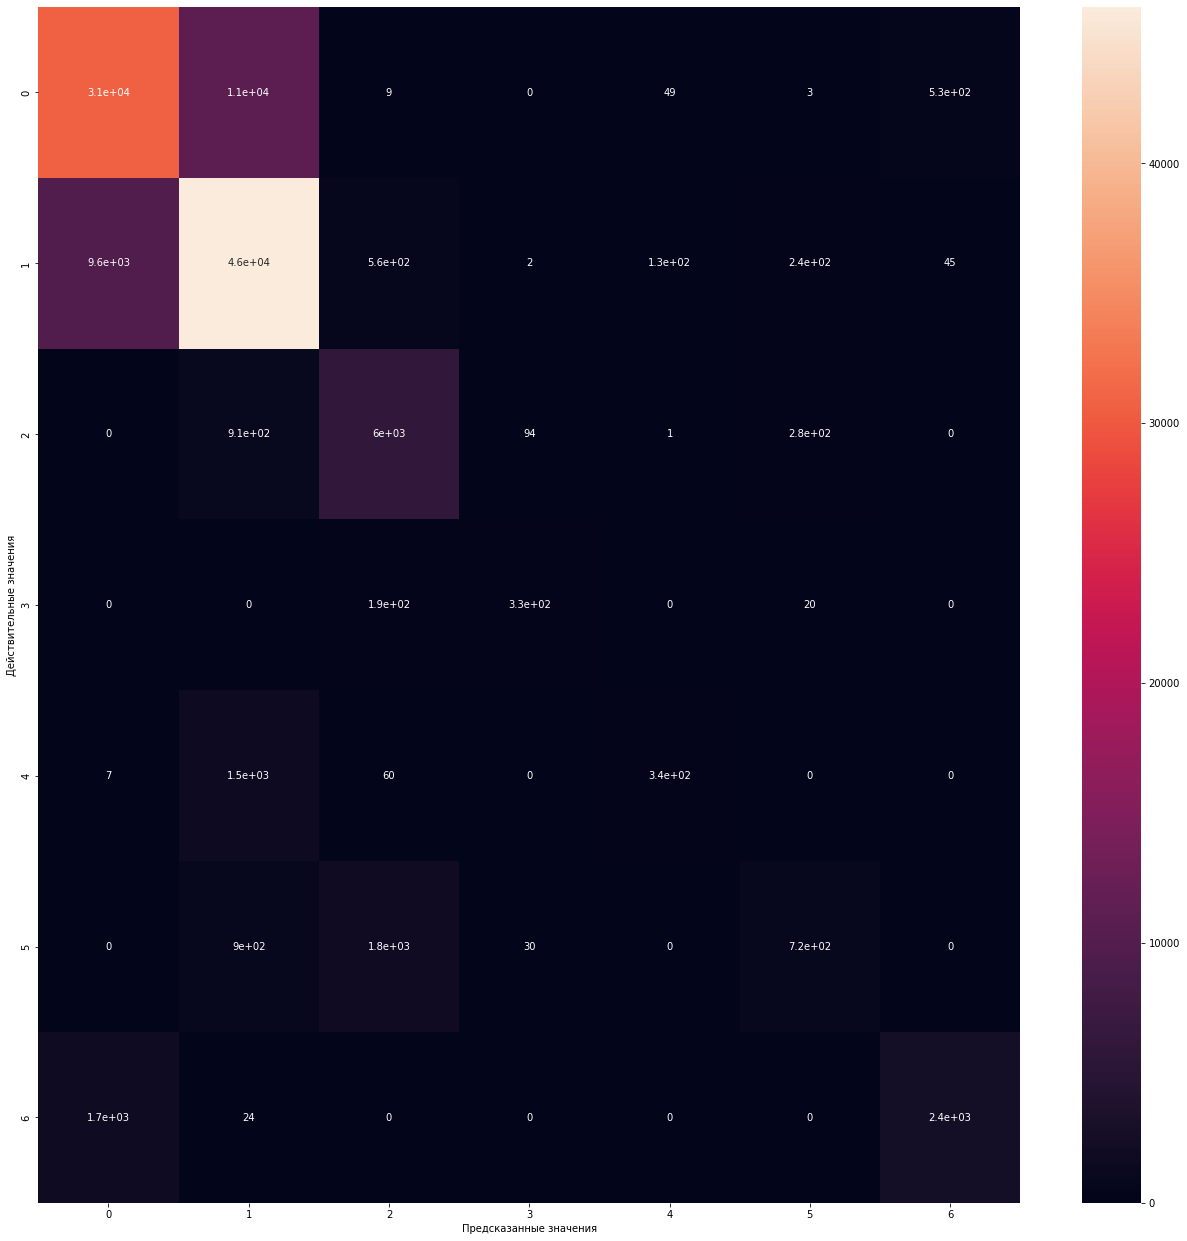

In [ ]:
%matplotlib inline

class_names = [1, 2, 3, 4, 5, 6, 7]
fig, ax = plt.subplots(figsize=(22, 22))

ticks = np.arange(len(class_names))

#Добавлем ось x
plt.xticks(ticks, class_names)
#Добавляем ось y
plt.yticks(ticks, class_names)

#Строим матрицу при помощи sns
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred2)), annot=True)
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения')

In [ ]:
print(metrics.classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           1       0.73      0.72      0.73     42275
           2       0.76      0.81      0.79     56602
           3       0.69      0.82      0.75      7269
           4       0.73      0.61      0.66       546
           5       0.65      0.18      0.28      1929
           6       0.57      0.21      0.30      3496
           7       0.80      0.58      0.67      4086

    accuracy                           0.74    116203
   macro avg       0.70      0.56      0.60    116203
weighted avg       0.74      0.74      0.73    116203



In [ ]:
#scoring = ['precision_macro', 'recall_macro']
#scores = cross_validate(gbc_raw, x_test, y_test, scoring=scoring)

In [ ]:
valid_x = np.array_split(x_train, 4)
valid_y = np.array_split(y_train, 4)

Провожу кросс-валидацию данных обучающей выборки для подтверждения точности модели. Вывод точности после каждой итерации

In [ ]:
for i in range(4):
  clf_v = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=0)
  for j in range(3):
    clf_v.fit(valid_x[j-i], valid_y[j-i])
  print(clf_v.score(valid_x[-i-1], valid_y[-i-1]))

In [ ]:
clf_v.score(x_test, y_test)

## Анализ данных

### Трансформация данных с помощью StandardScaler

In [12]:
sc = StandardScaler()

In [13]:
sc.fit(data)

StandardScaler()

In [14]:
dataT = pd.DataFrame(sc.transform(data))

In [207]:
dataT.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,-1.297805,-0.935157,-1.482820,-0.053767,-0.796273,-1.180146,0.330743,0.439143,0.142960,3.246283,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654
1,-1.319235,-0.890480,-1.616363,-0.270188,-0.899197,-1.257106,0.293388,0.590899,0.221342,3.205504,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654
2,-0.554907,-0.148836,-0.681563,-0.006719,0.318742,0.532212,0.816364,0.742654,-0.196691,3.126965,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654
3,-0.622768,-0.005869,0.520322,-0.129044,1.227908,0.474492,0.965786,0.742654,-0.536343,3.194931,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654
4,-1.301377,-0.988770,-1.616363,-0.547771,-0.813427,-1.256464,0.293388,0.540313,0.195215,3.165479,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654


In [208]:
dataT.shape

(581012, 54)

### Поиск зависимостей между целевым атрибутом и признаками

In [209]:
columns = data.to_dict().keys()

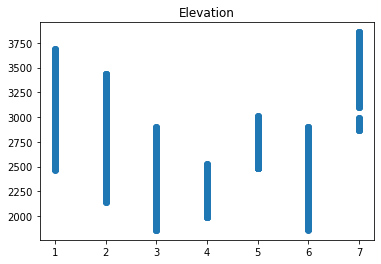

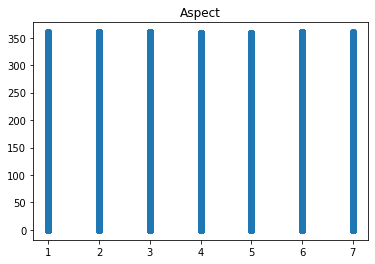

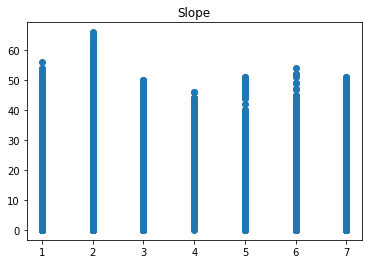

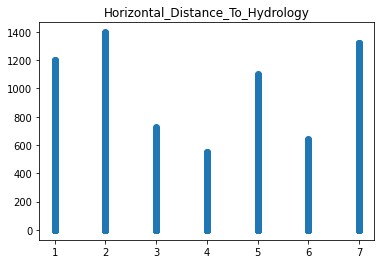

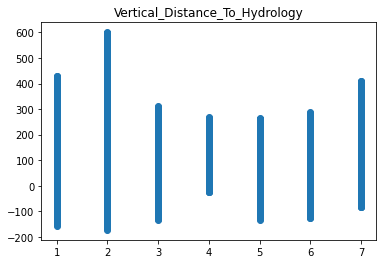

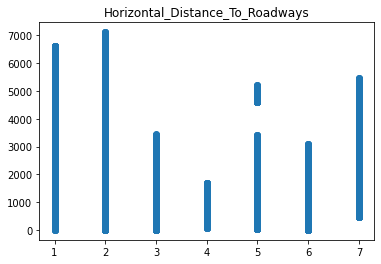

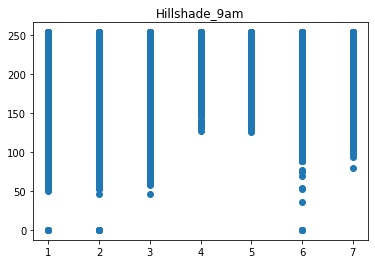

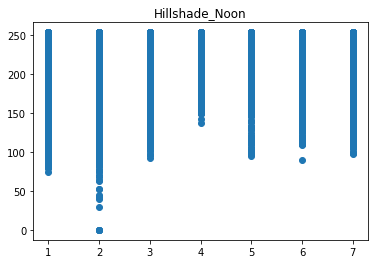

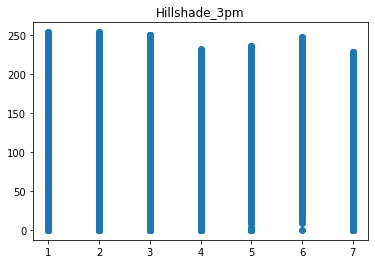

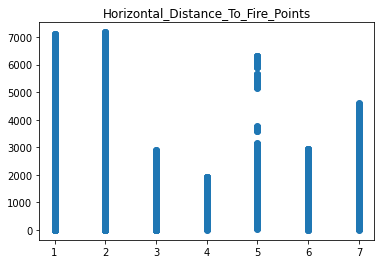

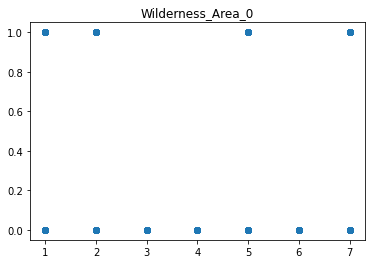

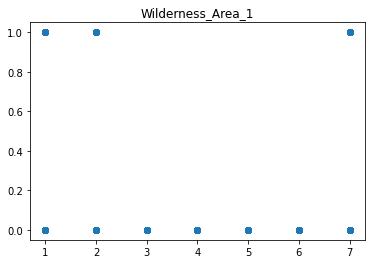

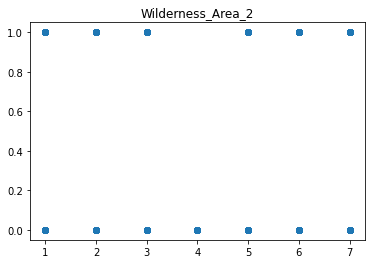

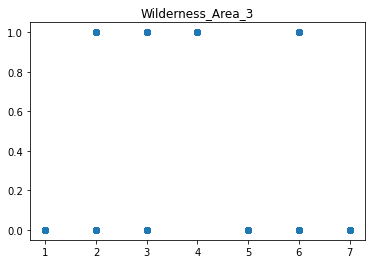

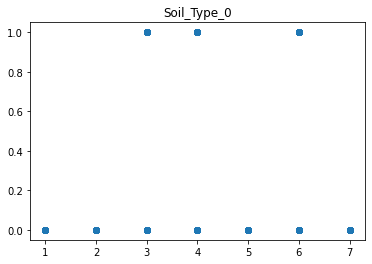

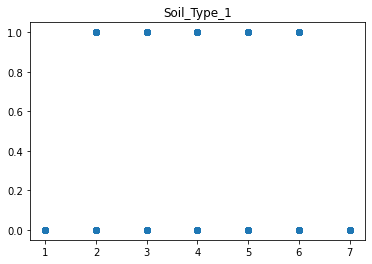

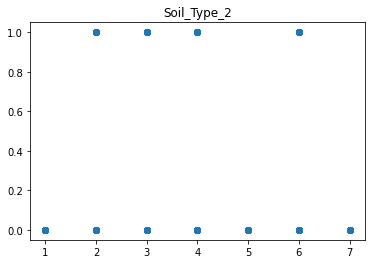

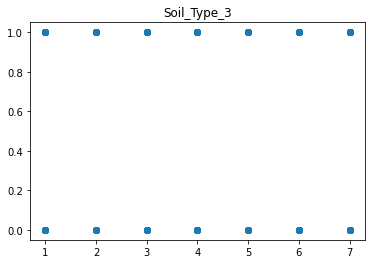

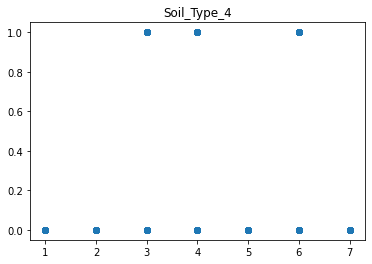

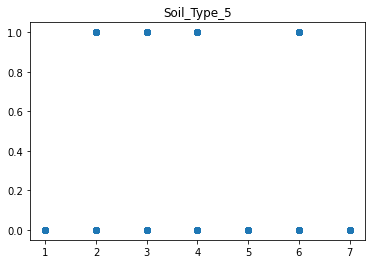

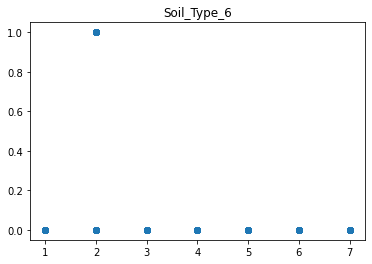

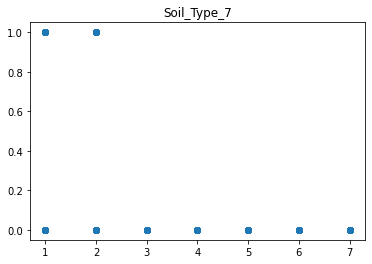

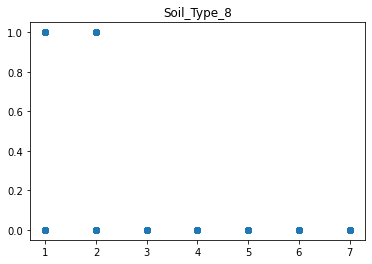

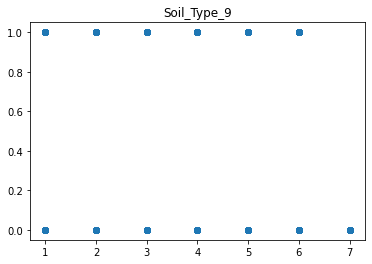

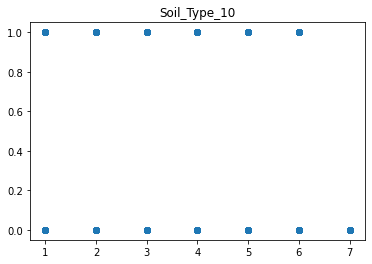

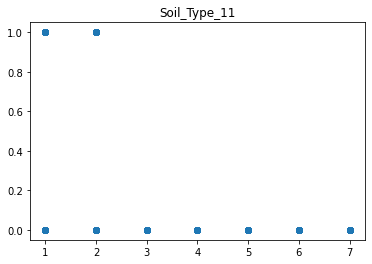

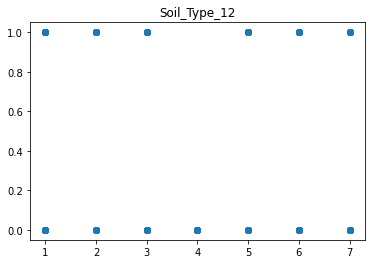

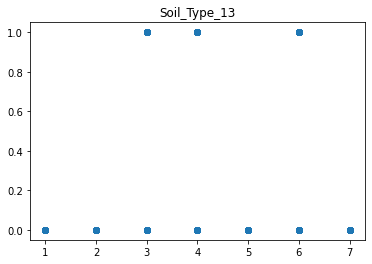

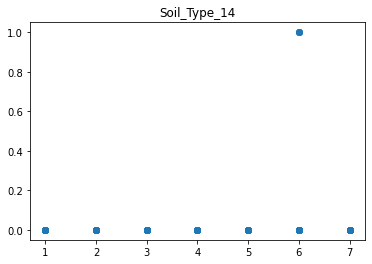

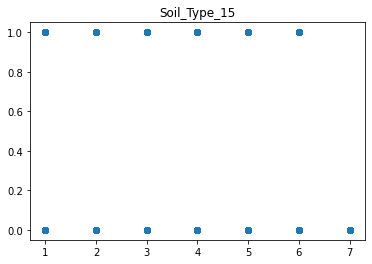

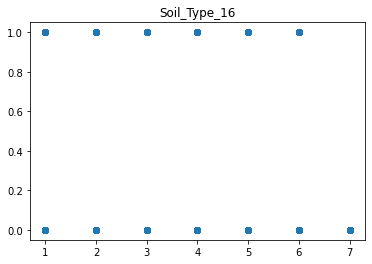

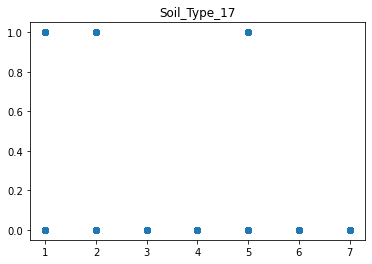

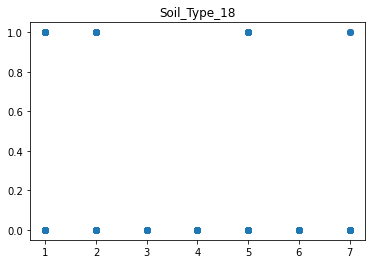

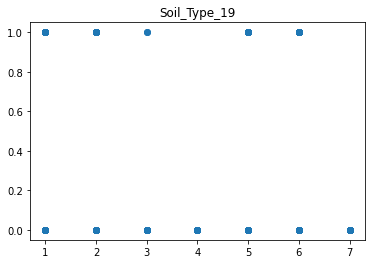

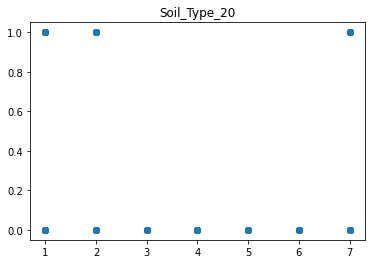

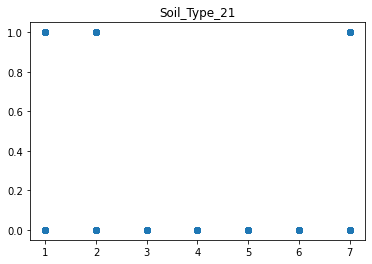

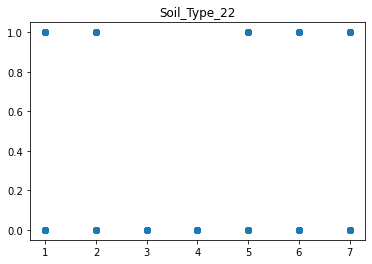

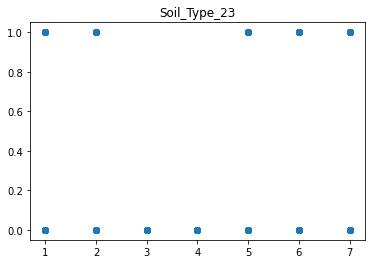

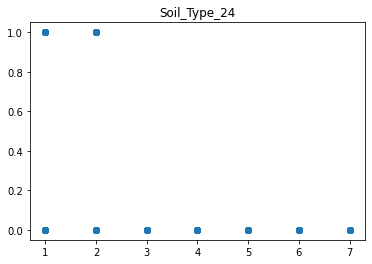

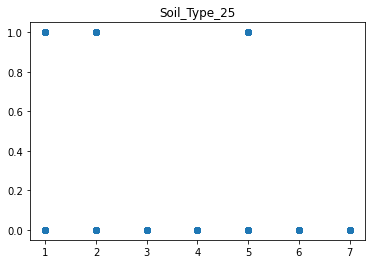

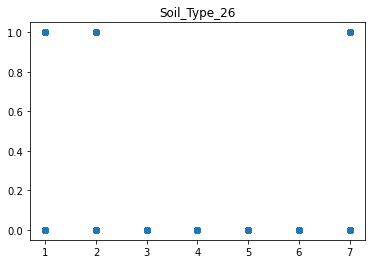

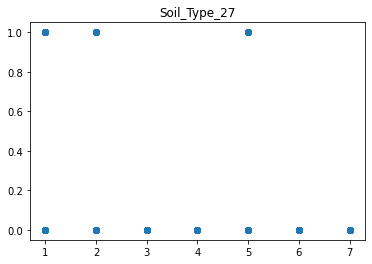

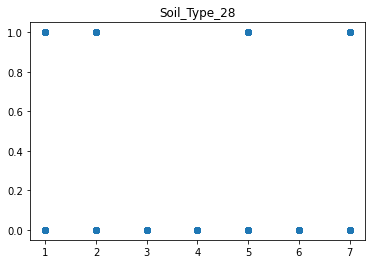

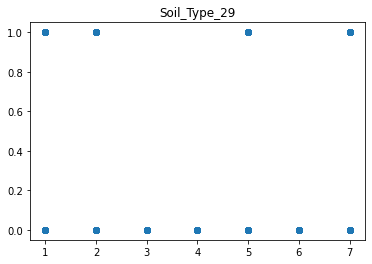

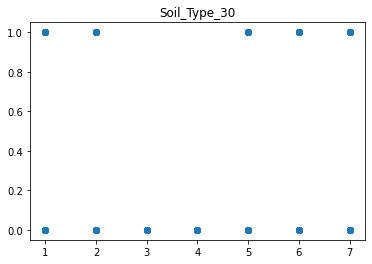

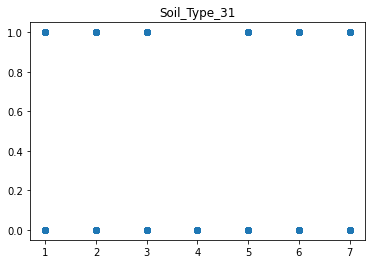

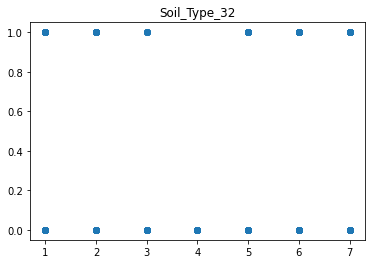

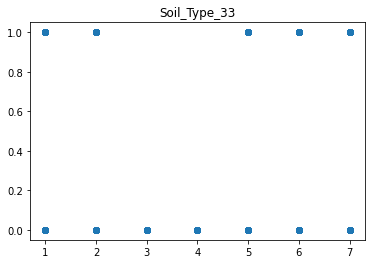

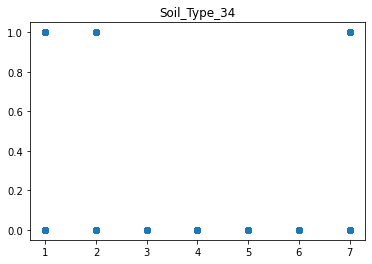

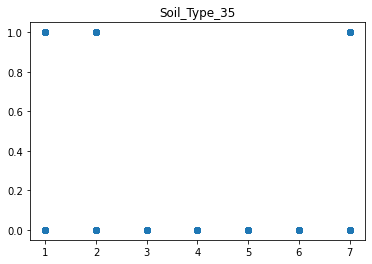

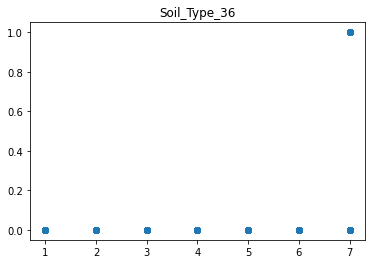

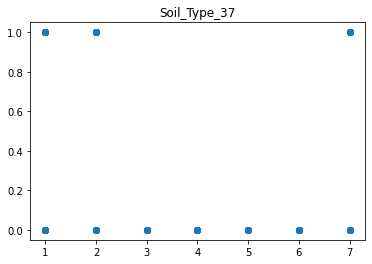

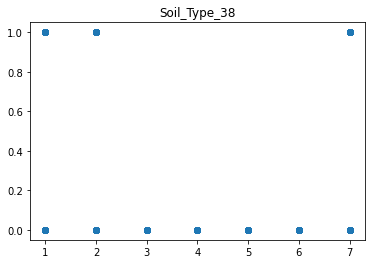

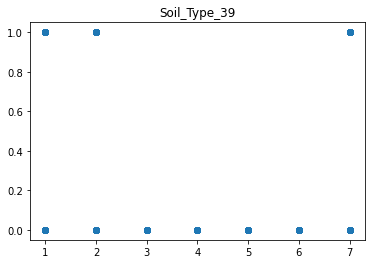

In [211]:
for column in columns:
    plt.scatter(target, data[column])
    plt.title(column)
    plt.show()

In [212]:
dataT.insert(54, "target", target)

In [213]:
for column in range(54):
  print("{} - corr: {}".format(column, dataT[column].corr(dataT["target"], method='pearson')))

0 - corr: -0.26955377763050464
1 - corr: 0.017079802032774274
2 - corr: 0.14828540507947907
3 - corr: -0.02031662163693506
4 - corr: 0.08166402150981635
5 - corr: -0.15344975909042438
6 - corr: -0.035415003646699444
7 - corr: -0.09642600166233192
8 - corr: -0.04828973004683914
9 - corr: -0.10893553610322682
10 - corr: -0.20391321381925592
11 - corr: -0.048058949741315325
12 - corr: 0.06684564296338946
13 - corr: 0.32319955390915317
14 - corr: 0.09082815211746842
15 - corr: 0.11813526031668656
16 - corr: 0.06806445519051268
17 - corr: 0.09967186439491588
18 - corr: 0.07788996111809382
19 - corr: 0.11295827807212458
20 - corr: -0.0004955165229846606
21 - corr: -0.0036667935899179524
22 - corr: -0.006109533783057859
23 - corr: 0.24387630152794465
24 - corr: 0.035378737686072824
25 - corr: -0.023601133704748575
26 - corr: 0.02440365592014329
27 - corr: 0.06556207167657435
28 - corr: 0.0064248452527425545
29 - corr: 0.00984434530257407
30 - corr: 0.09058230355856872
31 - corr: 0.00739038155

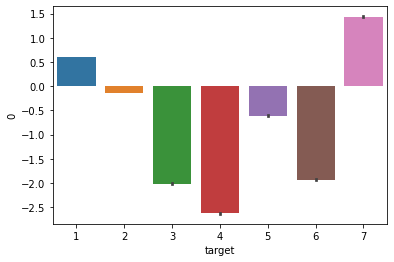

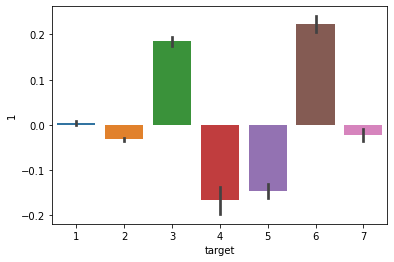

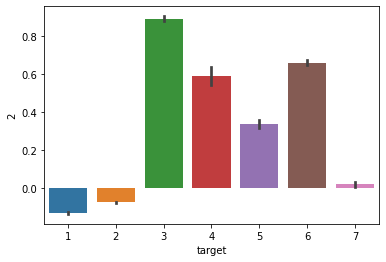

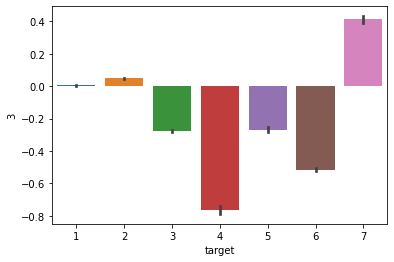

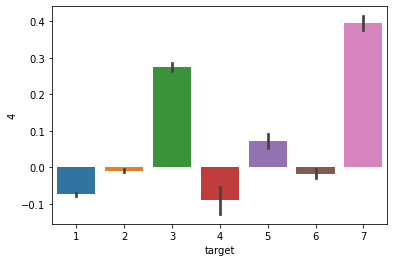

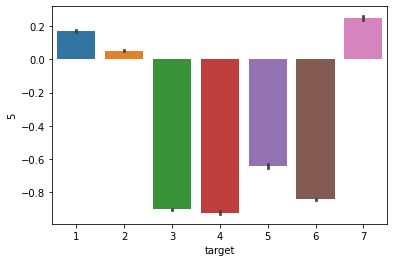

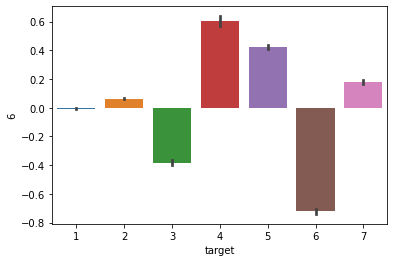

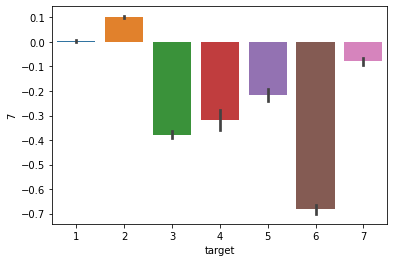

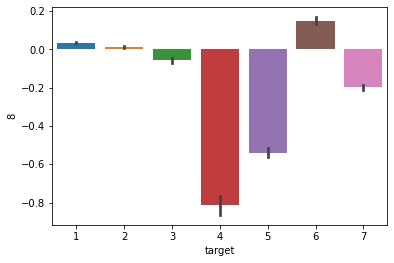

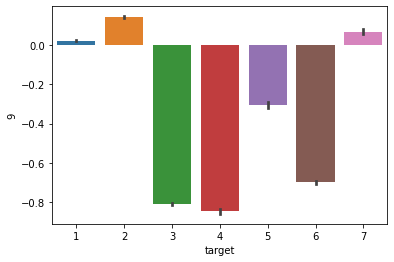

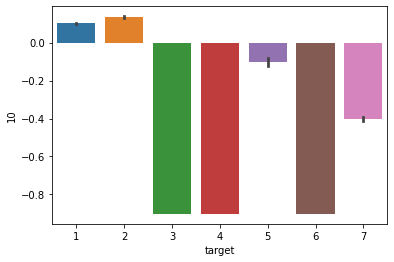

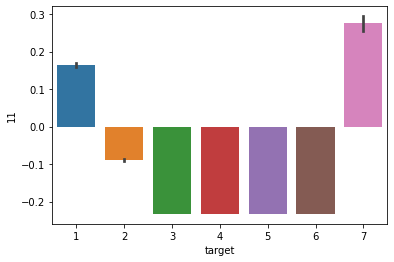

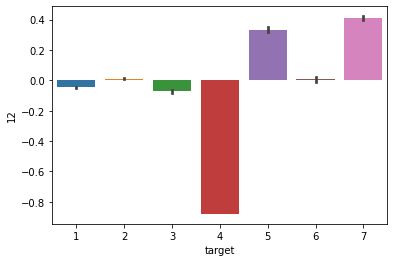

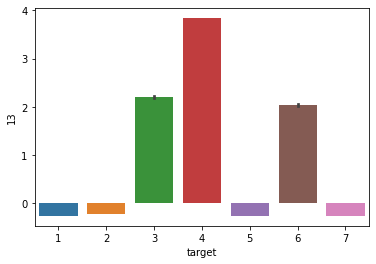

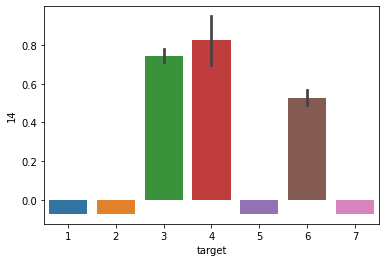

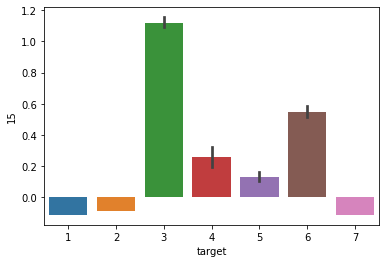

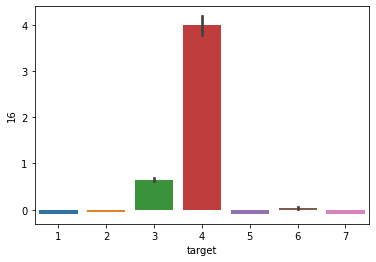

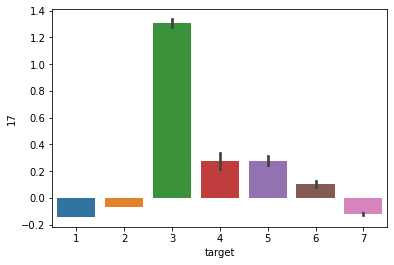

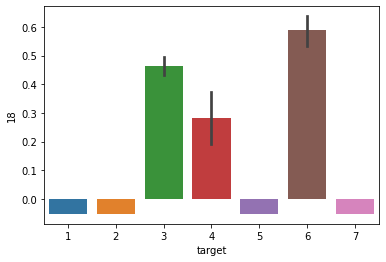

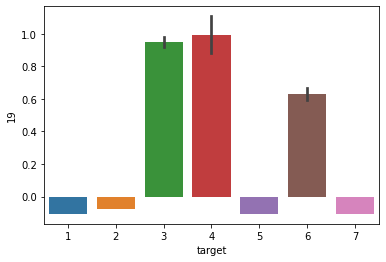

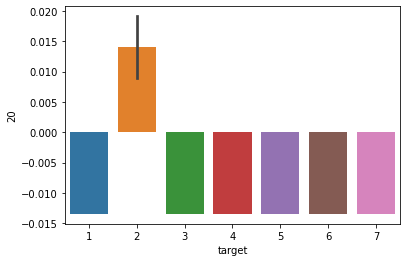

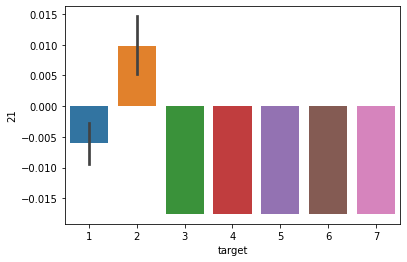

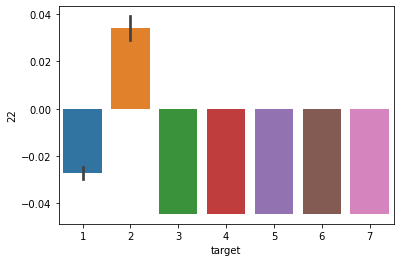

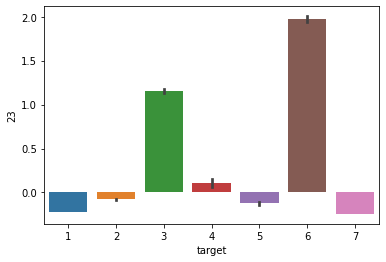

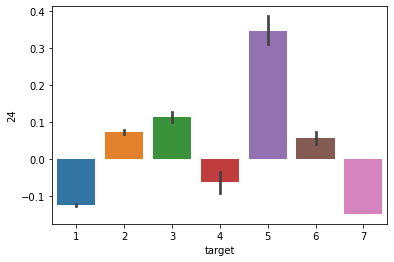

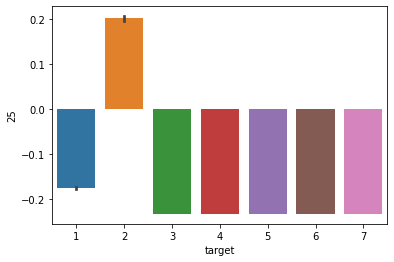

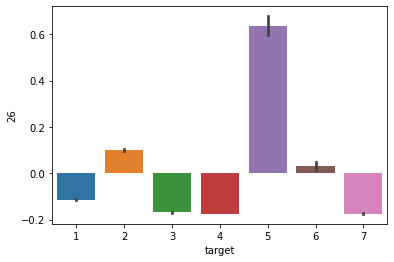

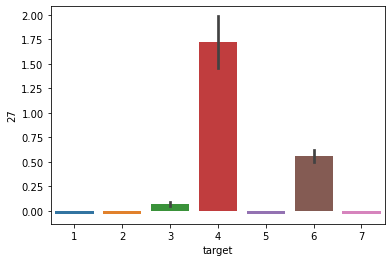

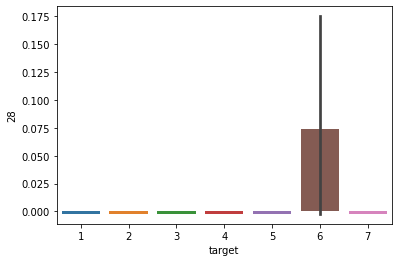

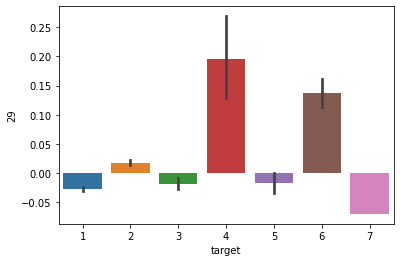

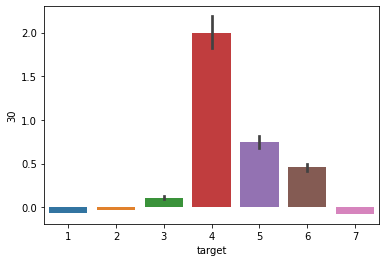

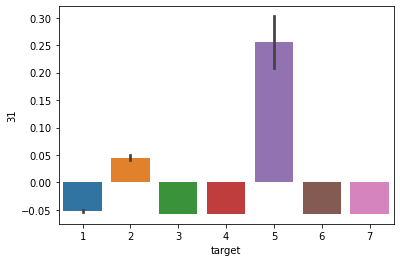

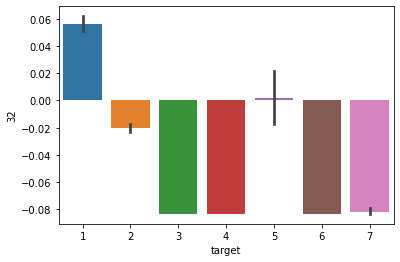

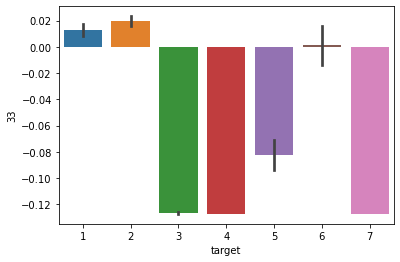

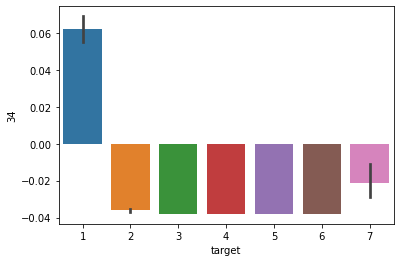

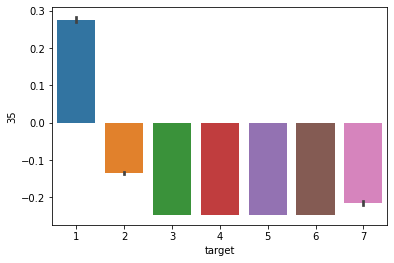

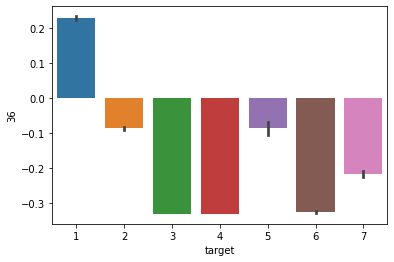

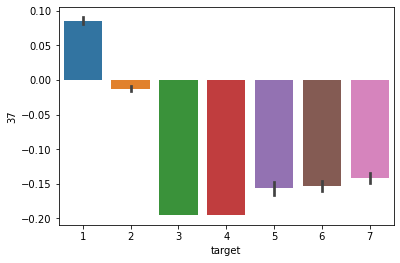

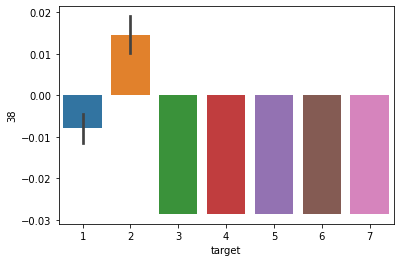

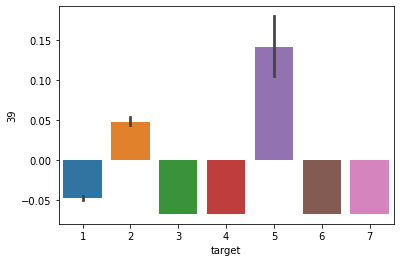

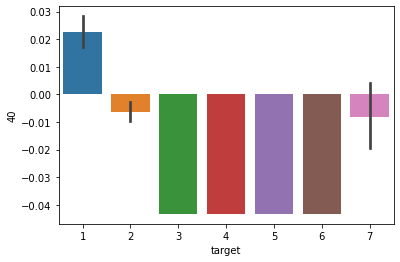

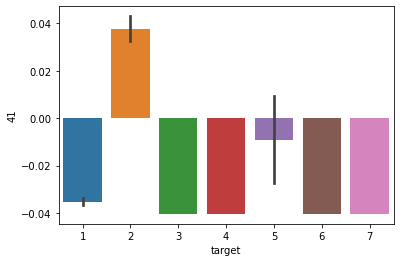

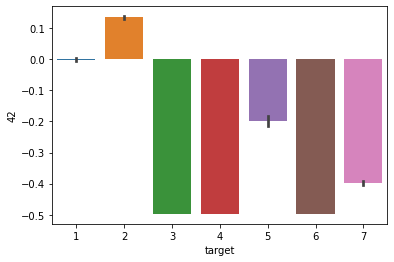

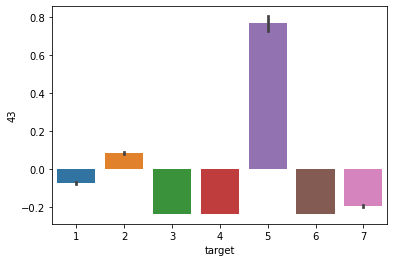

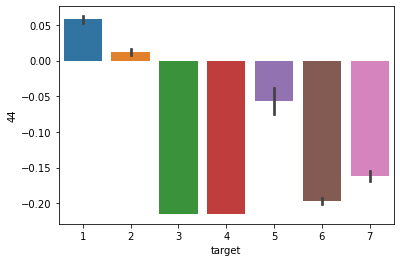

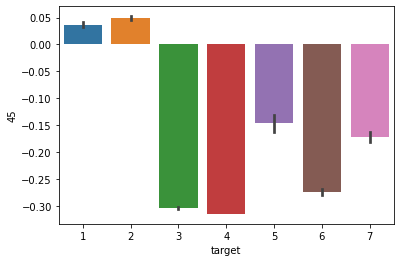

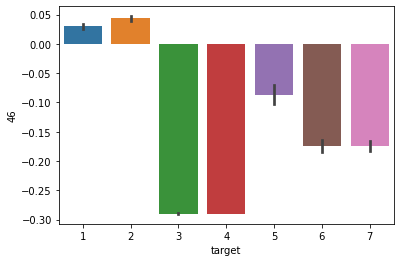

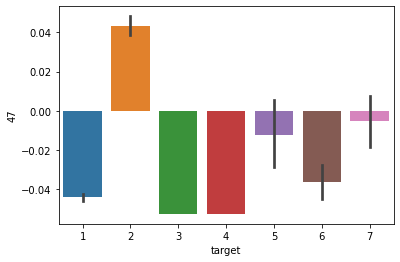

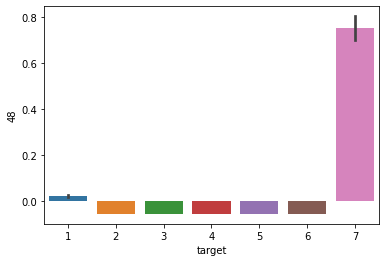

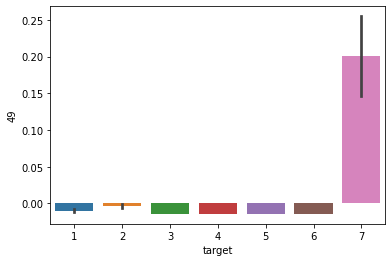

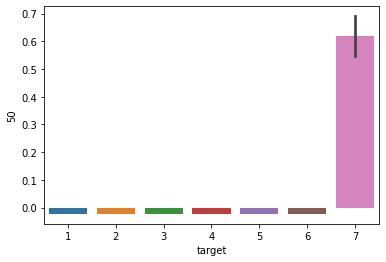

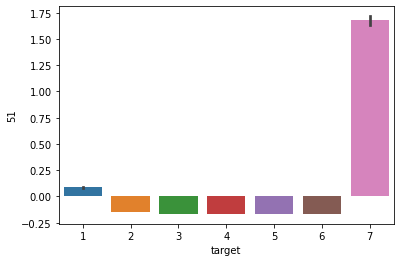

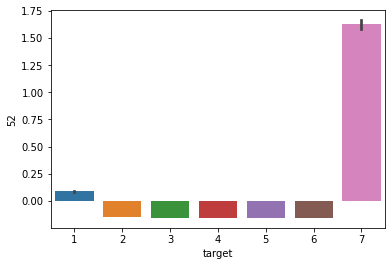

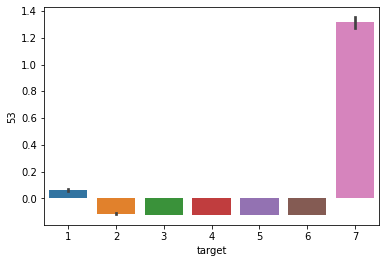

In [214]:
for column in range(54):
  sns.barplot(data=dataT, x="target", y=column)
  plt.show()

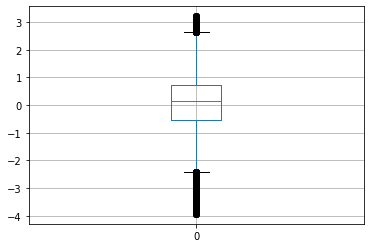

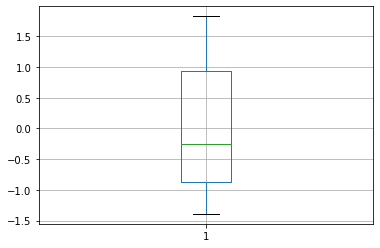

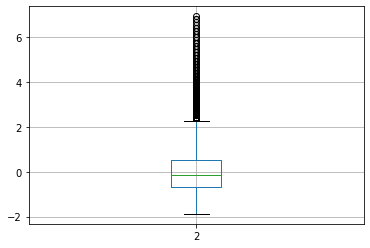

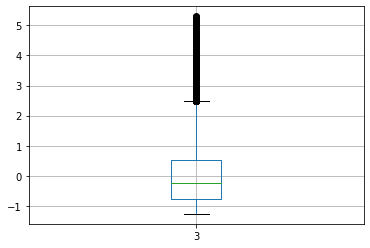

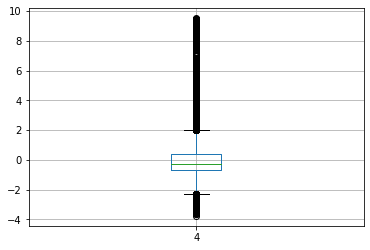

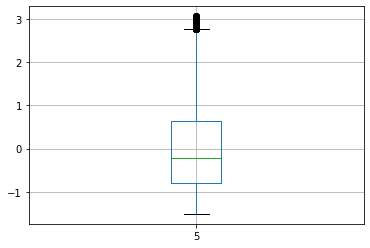

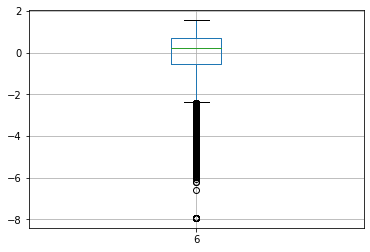

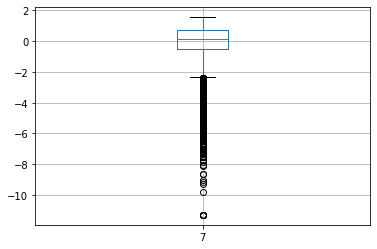

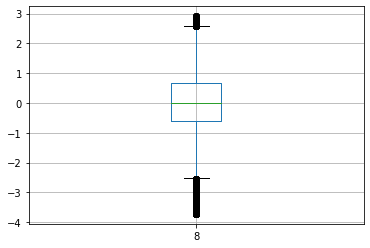

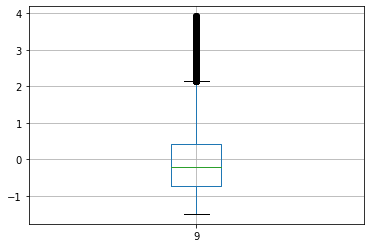

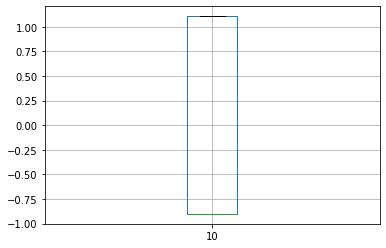

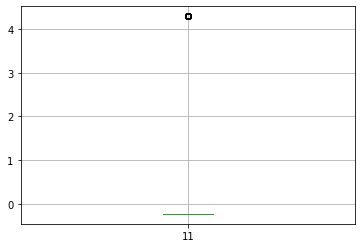

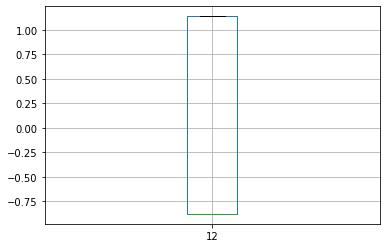

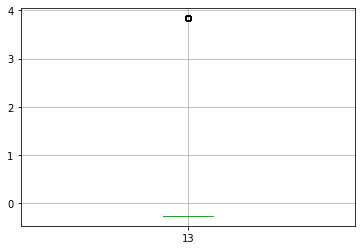

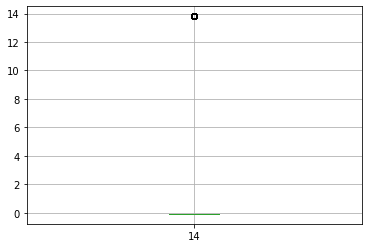

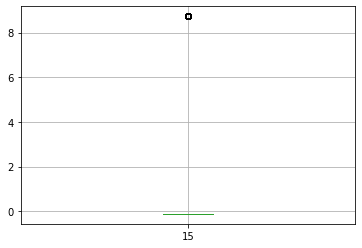

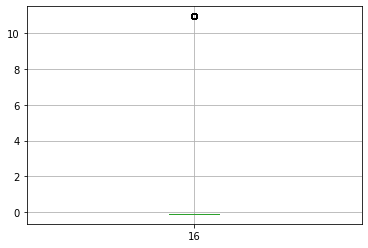

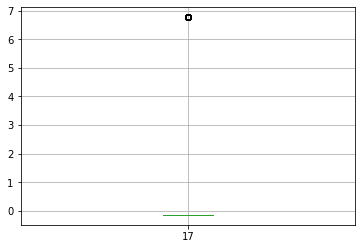

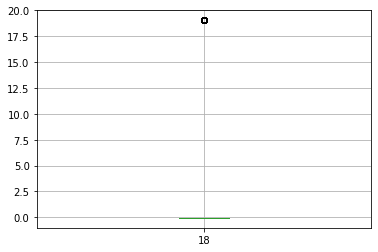

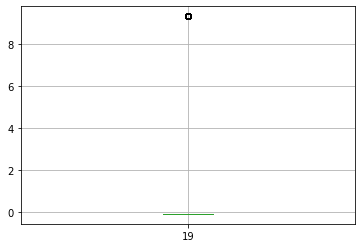

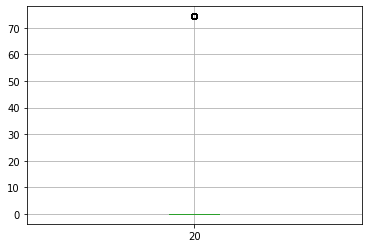

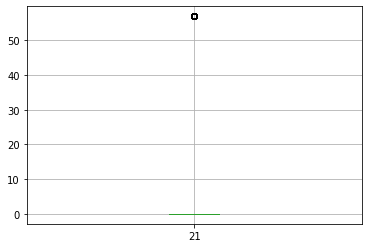

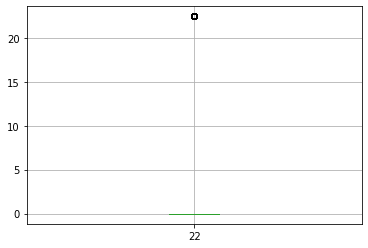

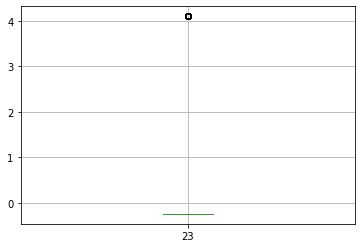

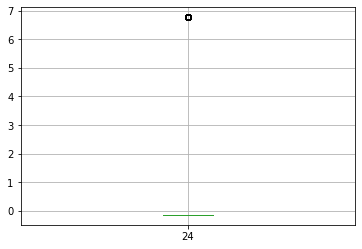

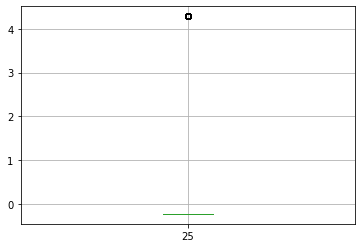

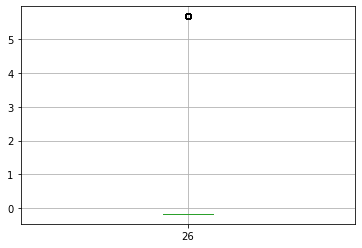

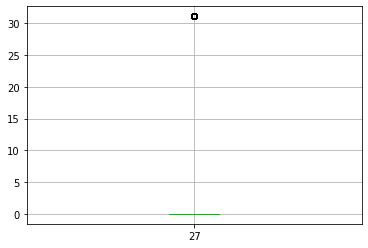

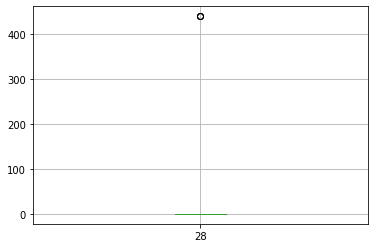

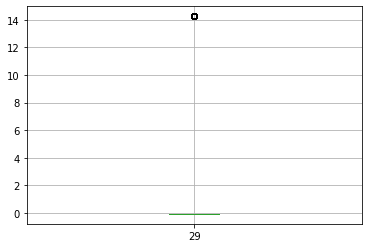

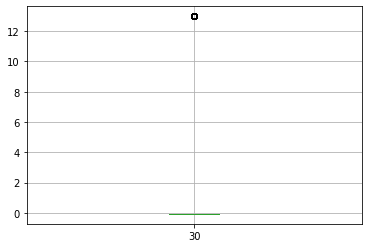

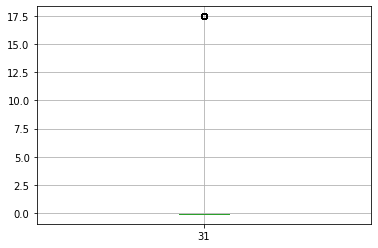

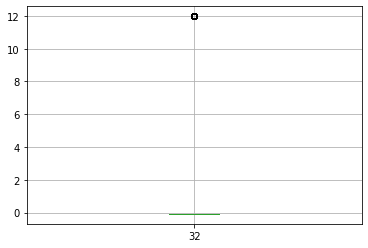

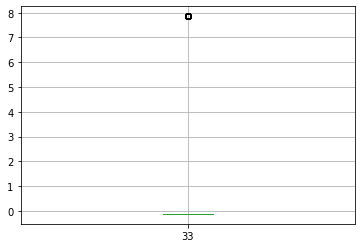

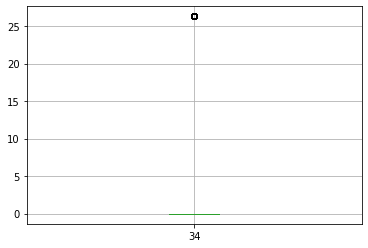

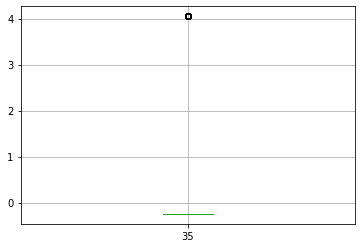

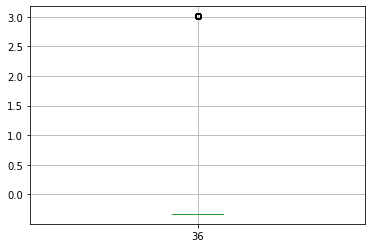

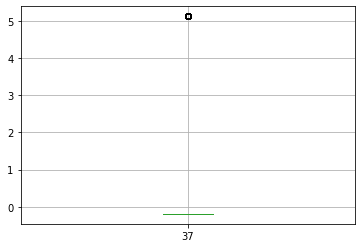

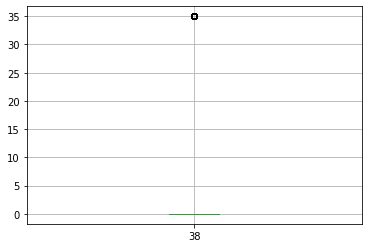

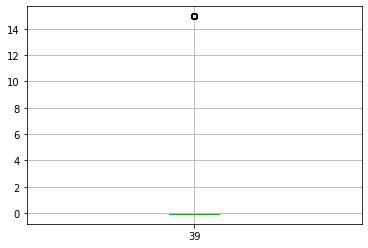

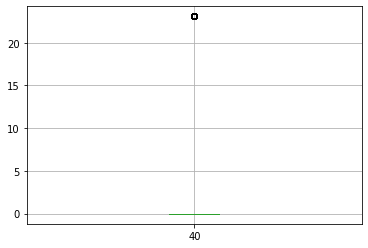

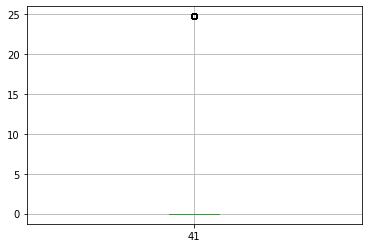

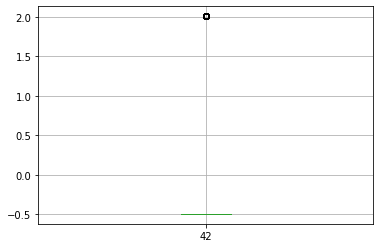

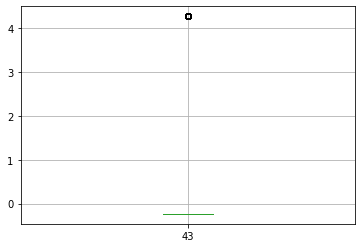

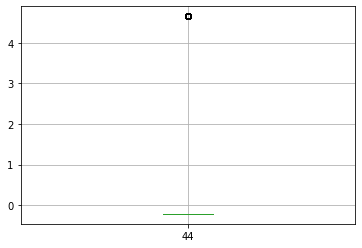

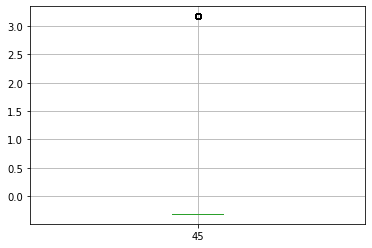

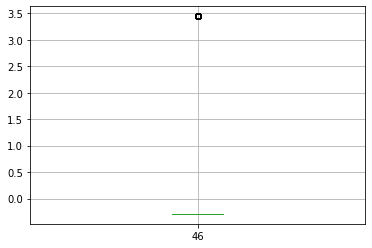

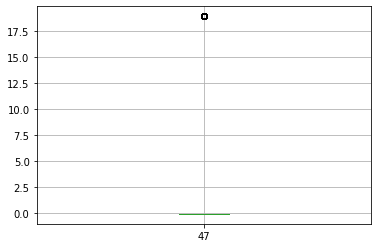

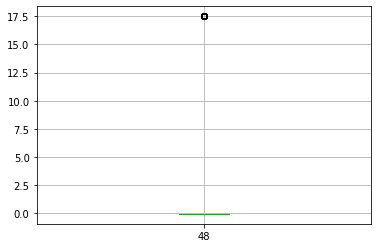

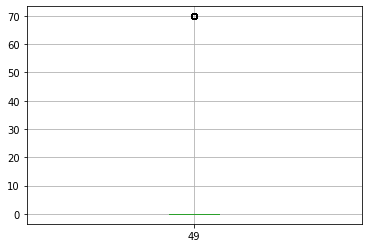

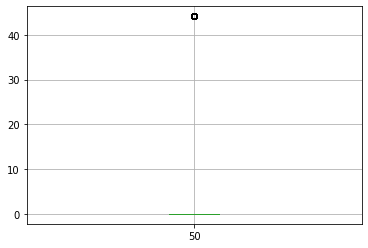

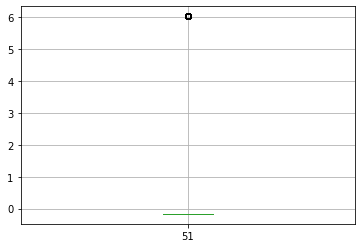

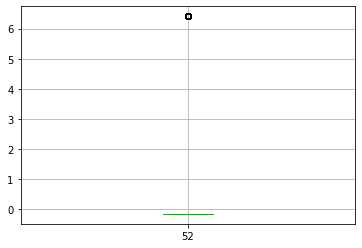

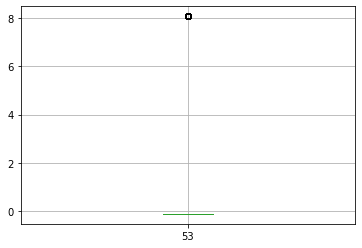

In [ ]:
for column in range(54):
  dataT.boxplot(column=[column])
  plt.show()

Как видим, в большинстве признаков присутствуют выбросы. При очистке выборки от них останется крайне мало значений, поэтому форматировать данные для улучшения качества улучшения надо другим способом

### Балансировка наименее многочисленных классов

In [106]:
dataT.shape

(581012, 54)

Наименее многочисленными являются классы 4, 5 и 6. Для балансировки датасета возьмем по 40.000 экземпляров классов 1 и 2, 30.000 экземпляров класса 7, а классы 4, 5 и 6 объединим в один. Позднее дополнительно сделаем малую модель для определения подкласса.

In [107]:
dataL = dataT.copy()
dataL.insert(54, "target", target)

In [108]:
dataL.shape

(581012, 55)

In [115]:
merged = dataL[dataL["target"] == 4].copy()
merged = merged.append(dataL[dataL["target"] == 5])
merged = merged.append(dataL[dataL["target"] == 6])
merged_target = merged["target"].copy()

<ipython-input-115-624d1b46ce77>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged = merged.append(dataL[dataL["target"] == 5])
<ipython-input-115-624d1b46ce77>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged = merged.append(dataL[dataL["target"] == 6])


In [118]:
merged["target"][merged["target"] == 5] = 4
merged["target"][merged["target"] == 6] = 4

<ipython-input-118-5345a4ae83b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["target"][merged["target"] == 5] = 4
<ipython-input-118-5345a4ae83b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["target"][merged["target"] == 6] = 4


In [123]:
merged.shape

(29607, 55)

In [124]:
print(merged["target"].value_counts().sort_index())

4    29607
Name: target, dtype: int64


In [125]:
copy_1 = dataL[dataL["target"] == 1].sample(n=40000)
copy_2 = dataL[dataL["target"] == 2].sample(n=40000)
copy_3 = dataL[dataL["target"] == 3].sample(n=30000)
copy_4 = dataL[dataL["target"] == 4].sample(n=25000, replace=True)
copy_5 = dataL[dataL["target"] == 5].sample(n=25000, replace=True)
copy_6 = dataL[dataL["target"] == 6].sample(n=25000, replace=True)
copy_7 = dataL[dataL["target"] == 7].sample(n=30000, replace=True)

In [126]:
dataL = pd.DataFrame()
dataL = dataL.append(copy_1)
dataL = dataL.append(copy_2)
dataL = dataL.append(copy_3)
dataL = dataL.append(merged)
dataL = dataL.append(copy_7)

<ipython-input-126-7ef84c48d1b2>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataL = dataL.append(copy_1)
<ipython-input-126-7ef84c48d1b2>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataL = dataL.append(copy_2)
<ipython-input-126-7ef84c48d1b2>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataL = dataL.append(copy_3)
<ipython-input-126-7ef84c48d1b2>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataL = dataL.append(merged)
<ipython-input-126-7ef84c48d1b2>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataL = dataL.append(copy_7)


In [127]:
dataL.shape

(169607, 55)

In [128]:
print(dataL["target"].unique())
print(dataL["target"].value_counts().sort_index())

[1 2 3 4 7]
1    40000
2    40000
3    30000
4    29607
7    30000
Name: target, dtype: int64


In [129]:
new_target = dataL["target"].copy()
dataL = dataL.drop(columns=["target"], axis=1)

In [130]:
merged = merged.drop(columns=["target"], axis=1)

In [131]:
dataL.shape

(169607, 54)

In [132]:
new_target.shape

(169607,)

### Обучение модели на обработанных данных

In [133]:
x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(dataL, new_target, test_size=0.2, random_state=True)

In [134]:
gbc = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, max_depth=100, random_state=0, verbose=3)

In [135]:
x_train_mini, x_test_mini, y_train_mini, y_test_mini = train_test_split(merged, merged_target, test_size=0.2, random_state=True)

In [136]:
gbc_mini = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, max_depth=10, random_state=0, verbose=3)

In [137]:
gbc.fit(x_train_bal, y_train_bal)

      Iter       Train Loss   Remaining Time 
         1           1.2210            5.72m
         2           0.9749            7.64m
         3           0.7946            8.09m
         4           0.6555            8.16m
         5           0.5449            8.05m
         6           0.4555            7.86m
         7           0.3823            7.63m
         8           0.3218            7.36m
         9           0.2715            7.04m
        10           0.2294            6.73m
        11           0.1942            6.42m
        12           0.1645            6.08m
        13           0.1395            5.76m
        14           0.1184            5.42m
        15           0.1006            5.09m
        16           0.0855            4.76m
        17           0.0727            4.41m
        18           0.0618            4.08m
        19           0.0526            3.75m
        20           0.0447            3.48m
        21           0.0381            3.16m
        2

GradientBoostingClassifier(max_depth=100, n_estimators=30, random_state=0,
                           verbose=3)

In [138]:
gbc_mini.fit(x_train_mini, y_train_mini)

      Iter       Train Loss   Remaining Time 
         1           0.7194           14.12s
         2           0.6016           26.65s
         3           0.5113           22.18s
         4           0.4391           20.40s
         5           0.3798           19.81s
         6           0.3296           19.12s
         7           0.2880           18.36s
         8           0.2526           16.99s
         9           0.2221           15.77s
        10           0.1954           14.68s
        11           0.1727           13.68s
        12           0.1530           12.76s
        13           0.1357           11.90s
        14           0.1207           11.07s
        15           0.1072           10.29s
        16           0.0955            9.53s
        17           0.0852            8.79s
        18           0.0761            8.06s
        19           0.0680            7.35s
        20           0.0607            6.65s
        21           0.0541            5.96s
        2

GradientBoostingClassifier(max_depth=10, n_estimators=30, random_state=0,
                           verbose=3)

In [139]:
y_pred3 = gbc.predict(x_test_bal)

In [140]:
np.unique(y_pred3, return_counts=True) #предсказанные значения

(array([1, 2, 3, 4, 7], dtype=int32), array([7633, 8726, 5967, 5631, 5965]))

In [141]:
np.unique(y_test_bal, return_counts=True) #действительные значения

(array([1, 2, 3, 4, 7], dtype=int32), array([8033, 8008, 6028, 5953, 5900]))

In [142]:
data_subclass = x_test_bal.iloc[np.where(y_pred3 == 4)].copy()

In [143]:
y_pred3_subclass = gbc_mini.predict(x_test_mini)

In [147]:
np.unique(y_pred3_subclass, return_counts=True)

(array([4, 5, 6], dtype=int32), array([ 571, 1919, 3432]))

In [148]:
np.unique(y_test_mini, return_counts=True)

(array([4, 5, 6], dtype=int32), array([ 588, 1923, 3411]))

In [144]:
data_subclass.shape

(5631, 54)

In [145]:
metrics.accuracy_score(y_test_bal, y_pred3)

0.9082306467779022

In [146]:
metrics.accuracy_score(y_test_mini, y_pred3_subclass)

0.9836203985140155

Итоговая точность модели составляет 90% для определения классов 1-7 с объединенным 4-ым, и 98% для определения подкласса. В результате эффективность модели увеличивается после обработки данных. Для практического использования две модели gbc и gbc_mini нужно использовать в связке для формирования итогового списка классов от 1 до 7.

### Проверка качества обучения

Для проверки качества обучения двух моделей проведем классификацию на изначальных трансформированных StandardScaler данных

In [165]:
dataX = dataT.copy()

In [166]:
dataX.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,-1.297805,-0.935157,-1.482820,-0.053767,-0.796273,-1.180146,0.330743,0.439143,0.142960,3.246283,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654
1,-1.319235,-0.890480,-1.616363,-0.270188,-0.899197,-1.257106,0.293388,0.590899,0.221342,3.205504,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654
2,-0.554907,-0.148836,-0.681563,-0.006719,0.318742,0.532212,0.816364,0.742654,-0.196691,3.126965,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654
3,-0.622768,-0.005869,0.520322,-0.129044,1.227908,0.474492,0.965786,0.742654,-0.536343,3.194931,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654
4,-1.301377,-0.988770,-1.616363,-0.547771,-0.813427,-1.256464,0.293388,0.540313,0.195215,3.165479,...,-0.21498,-0.315238,-0.290284,-0.05273,-0.057143,-0.014313,-0.022653,-0.165956,-0.156014,-0.123654


In [169]:
x_train, x_test, y_train, y_test = train_test_split(dataX, target, test_size=0.2, random_state=True)

In [193]:
res = gbc.predict(x_test)

In [173]:
np.unique(res, return_counts=True)

(array([1, 2, 3, 4, 7], dtype=int32),
 array([41344, 56005,  7542,  6775,  4537]))

In [194]:
data_sub = x_test_bal.iloc[np.where(res == 4)].copy()

In [195]:
data_sub.shape

(6775, 54)

In [201]:
temp = np.where(res == 4)[0]
indexes = []
for element in range(len(temp)):
  indexes.append([element, temp[element]])
indexes

[[0, 2],
 [1, 6],
 [2, 18],
 [3, 24],
 [4, 29],
 [5, 101],
 [6, 144],
 [7, 160],
 [8, 194],
 [9, 219],
 [10, 220],
 [11, 229],
 [12, 266],
 [13, 311],
 [14, 315],
 [15, 319],
 [16, 331],
 [17, 344],
 [18, 422],
 [19, 436],
 [20, 459],
 [21, 502],
 [22, 547],
 [23, 585],
 [24, 590],
 [25, 620],
 [26, 635],
 [27, 651],
 [28, 686],
 [29, 716],
 [30, 725],
 [31, 754],
 [32, 783],
 [33, 787],
 [34, 789],
 [35, 790],
 [36, 813],
 [37, 817],
 [38, 896],
 [39, 912],
 [40, 913],
 [41, 931],
 [42, 939],
 [43, 953],
 [44, 959],
 [45, 990],
 [46, 1010],
 [47, 1011],
 [48, 1012],
 [49, 1018],
 [50, 1033],
 [51, 1048],
 [52, 1050],
 [53, 1076],
 [54, 1077],
 [55, 1083],
 [56, 1099],
 [57, 1132],
 [58, 1143],
 [59, 1152],
 [60, 1171],
 [61, 1173],
 [62, 1178],
 [63, 1204],
 [64, 1208],
 [65, 1228],
 [66, 1243],
 [67, 1303],
 [68, 1323],
 [69, 1347],
 [70, 1375],
 [71, 1407],
 [72, 1420],
 [73, 1434],
 [74, 1446],
 [75, 1450],
 [76, 1506],
 [77, 1533],
 [78, 1549],
 [79, 1563],
 [80, 1569],
 [81, 1573

In [197]:
res_sub = gbc_mini.predict(data_sub)

In [202]:
for i in indexes:
  res[i[1]] = res_sub[i[0]]

In [203]:
np.unique(res, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([41344, 56005,  7542,   546,  2463,  3766,  4537]))

In [204]:
print(metrics.classification_report(y_test, res))

              precision    recall  f1-score   support

           1       0.91      0.89      0.90     42275
           2       0.92      0.91      0.92     56602
           3       0.94      0.98      0.96      7269
           4       0.97      0.97      0.97       546
           5       0.76      0.97      0.86      1929
           6       0.90      0.97      0.94      3496
           7       0.89      0.99      0.94      4086

    accuracy                           0.91    116203
   macro avg       0.90      0.95      0.92    116203
weighted avg       0.91      0.91      0.91    116203



Как видно из результатов проверки точности, работа в связке двух моделей дала увеличение точности до 90% на необработанных данных.

Text(0.5, 177.0, 'Предсказанные значения')

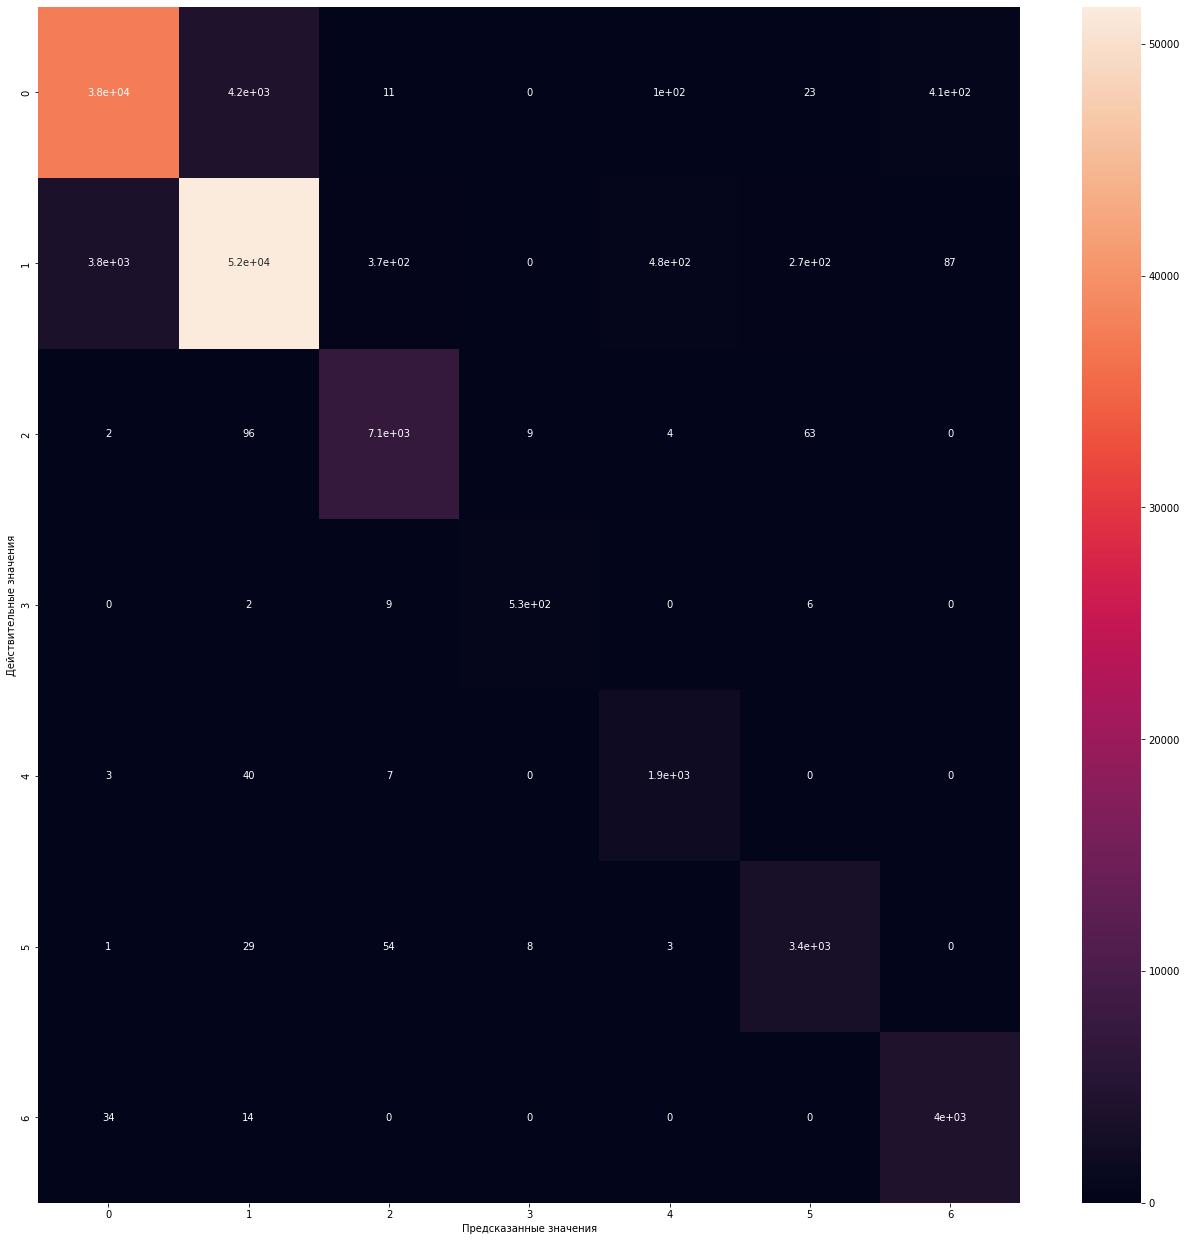

In [205]:
%matplotlib inline

class_names = [1, 2, 3, 4, 5, 6, 7]
fig, ax = plt.subplots(figsize=(22, 22))

ticks = np.arange(len(class_names))

#Добавлем ось x
plt.xticks(ticks, class_names)
#Добавляем ось y
plt.yticks(ticks, class_names)

#Строим матрицу при помощи sns
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, res)), annot=True)
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения')

## Не использованный код и ошибки

In [ ]:
#dataT = pd.DataFrame(sc.transform(data))

In [ ]:
#dataT.shape

(581012, 54)

In [ ]:
#x_train_fin, x_test_fin, y_train_fin, y_test_fin = train_test_split(dataT, target, test_size=0.2, random_state=True)

In [ ]:
#gbc.score(x_test_fin, y_test_fin)

0.42578935139368174

In [ ]:
#from sklearn.ensemble import RandomForestClassifier

In [ ]:
#rfc = RandomForestClassifier(max_depth=1000, random_state=0)

In [ ]:
#rfc.fit(x_train_fin, y_train_fin)

RandomForestClassifier(max_depth=1000, random_state=0)

In [ ]:
#rfc.score(x_test_fin, y_test_fin)

0.9556379783654467

In [ ]:
#cdata = data[data.columns.drop(list(data.filter(regex='Soil_Type_')))]
#cdata = cdata[cdata.columns.drop(list(data.filter(regex='Wilderness')))]

In [ ]:
#cdata.describe()

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(cdata, target, test_size=0.2, random_state=True)

In [ ]:
#print(metrics.classification_report(y_test, y_pred3))

In [ ]:
#data["target"] = target

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(dataT, target, test_size=0.2, random_state=True)

In [ ]:
#for column in columns:
  #if (data[column].corr(data["target"], method='pearson') < 0):
    #if not ("Soil" in column):
      #data = data.drop(columns=[column], axis=1)
      #print(column)
#data

Elevation
Horizontal_Distance_To_Hydrology
Horizontal_Distance_To_Roadways
Hillshade_9am
Hillshade_Noon
Hillshade_3pm
Horizontal_Distance_To_Fire_Points
Wilderness_Area_0
Wilderness_Area_1


,Aspect,Slope,Vertical_Distance_To_Hydrology,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,target
0,51.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,56.0,2.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,139.0,9.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,155.0,18.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,45.0,2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,153.0,20.0,17.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581008,152.0,19.0,12.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581009,159.0,17.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581010,170.0,15.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [ ]:
#dataT = dataT.drop(columns=["target"], axis=1)
#dataT.head()

,Aspect,Slope,Vertical_Distance_To_Hydrology,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,...,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,51.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,56.0,2.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,139.0,9.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,155.0,18.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,45.0,2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#quantiles = {}
#for column in columns:
  #if not(("Soil" in column) | ("Wild" in column) | ("target" in column)):
    #q25 = data[column].quantile(.25)
    #q75 = data[column].quantile(.75)
    #print(q25)
    #print(q75)
    #quantiles[column] = [q25, q75]
#print(quantiles)

2809.0
3163.0
58.0
260.0
9.0
18.0
108.0
384.0
7.0
69.0
1106.0
3328.0
198.0
231.0
213.0
237.0
119.0
168.0
1024.0
2550.0
{'Elevation': [2809.0, 3163.0], 'Aspect': [58.0, 260.0], 'Slope': [9.0, 18.0], 'Horizontal_Distance_To_Hydrology': [108.0, 384.0], 'Vertical_Distance_To_Hydrology': [7.0, 69.0], 'Horizontal_Distance_To_Roadways': [1106.0, 3328.0], 'Hillshade_9am': [198.0, 231.0], 'Hillshade_Noon': [213.0, 237.0], 'Hillshade_3pm': [119.0, 168.0], 'Horizontal_Distance_To_Fire_Points': [1024.0, 2550.0]}


In [ ]:
#for column in quantiles.keys():
  #print(column)
  #data = data.drop(data[data[column] > quantiles[column][1]].index)
  ##data = data.drop(data[data[column] < quantiles[column][0]].index)
#data.shape

Elevation
Aspect
Slope
Horizontal_Distance_To_Hydrology
Vertical_Distance_To_Hydrology
Horizontal_Distance_To_Roadways
Hillshade_9am
Hillshade_Noon
Hillshade_3pm
Horizontal_Distance_To_Fire_Points


(288, 55)

In [ ]:
#target = data["target"]
#data = data.drop(columns=["target"], axis=1)
#target.shape

(288,)

In [ ]:
#dataRaw = ctypes.get('data').drop(columns=["target"], axis=1)
#targetRaw = ctypes.get('target')

In [ ]:
#clf.score(dataRaw, targetRaw)

0.5730019345555686